<h1><center> <b><ins>PSO-CNN-MVF Strategy</ins></b> </center></h1>

<h2> <b><ins>Introduction</ins></b> </h2>

This notebook implements the methodology presented in the paper: ["Clustering-based return prediction model for stock pre-selection in portfolio optimization using PSO-CNN+MVF", Journal of King Saud University - Computer and Information Sciences, Volume 35, Issue 9, 2023](https://www.sciencedirect.com/science/article/pii/S1319157823002914?ref=pdf_download&fr=RR-2&rr=95753186e87ff477).

The paper proposes a dynamic stock portfolio selection framework that combines:
- Particle Swarm Optimization (PSO) for hyperparameter tuning
- Deep learning model (CNN) for return prediction
- Multi-Factor Models to select features based on economic and technical factors
- Clustered stock groups to reduce overfitting and increase stability
- Optimising portfolios via MVF to then calculate returns and various metrics

This notebook replicates and adapts their framework to construct a data-driven, ML-optimized investment strategy.

<h2> <b><ins>Guide</ins></b> </h2>

### Data Preparation
- Download historical daily price and volume data for S&P 500 stocks
- Filter to most liquid stocks by average dollar volume and choose the top 21 stocks with full history of data
- Compute features:
    - 10 various technical indicators
    - 4 Lagged returns
- Split data into training, validation and testing data

### Stock Clustering
- Calculate the means and standard deviations of each scaled feature for each stock
- Group stocks into clusters via KMeans based on these statistics, this controls overfitting

### Representative Features
- For each cluster, we will take the daily mean of all the scaled features of the stocks to come up with a representative set of features for each cluster daily
- This reduces complexity of future models since we will not have to deal with 21 individual stocks

### CNN-LTSM Feature Selection Model
- Use a novel approach to see for each cluster, which features are most important and only use those for our future models

### PSO Hyperparameter Optimisation Model
- For our future CNN model, use a PSO to find the optimal parameters (filters and learning rate)

### CNN Return Prediction Model
- Using said parameters, predict future returns for each cluster

### MVF Portfolio Optimisation
- Use MVF to find the optimal set of weights for each day to invest in

### Benchmark Comparison and Results
- Compare against S&P500 itself across the same time period
- Calculate various metrics such as Sharpe Ratio, Win Rate, Drawdown and more
- Also take into account of transaction costs to see if strategy is still profitable

In [158]:
# Import popular required libraries
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Import our self made Technical Indicators file
from Technical_Indicators import TI

# Import scaling libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import K-Means Clustering libraries
from sklearn.cluster import KMeans
import sklearn.cluster as cluster
import sklearn.metrics as metrics

# Import Machine Learning libraries for PSO,CNN and LTSM models
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import gc

# Import our self made Portfolio Optimisation Parameter file to calculate covariance matrices
import portfolio_params as params
# Import CvxPy convex optimiser to find optimal weights for our MVP problem
import cvxpy as cp

In [121]:
# Load our S&P500 CSV and compute average dollar volume
df = pd.read_csv('s&p500.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index(['date', 'ticker'], inplace=True)
df['dollar_volume'] = (df['Close'] * df['Volume']) / 1e6
liq = df['dollar_volume'].groupby('ticker').mean()

# Sort by liquidity
sorted_liq = liq.sort_values(ascending=False)

# Declare date range
start_date = '2012-10-15'
end_date = '2024-12-31'

# Initialise list of liquid tickers with full data
valid_tickers = []
for ticker in sorted_liq.index:
    try:
        data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True, progress=False)
        if not data.empty:
            first_date = data.index.min()
            # Ensure full date range (or nearly full)
            if first_date <= pd.to_datetime(start_date):
                valid_tickers.append(ticker)
        # Stop once we have 21 valid tickers
        if len(valid_tickers) == 21:
            break
    except Exception as e:
        print(f"Error with {ticker}: {e}")
        continue

# Download historical data for valid tickers
df = yf.download(tickers=valid_tickers,
                 start=start_date, end=end_date,
                 auto_adjust=True).stack(future_stack=True)
df.index.names = ['date', 'ticker']
df

[*********************100%***********************]  21 of 21 completed


Price                   Close        High         Low        Open     Volume
date       ticker                                                           
2012-10-15 AAPL     19.159100   19.170267   18.829801   19.086358  432502000
           AMD       2.750000    2.830000    2.730000    2.790000   26746100
           AMZN     12.209000   12.239000   11.925500   12.142500   59196000
           AVGO      2.412023    2.424378    2.383681    2.405483   17144000
           BA       60.174839   60.199824   59.700104   59.841690    3858000
...                       ...         ...         ...         ...        ...
2024-12-30 NVDA    137.467804  140.247354  133.998363  134.808230  167734700
           TSLA    417.410004  427.000000  415.750000  419.399994   64941000
           UNH     502.074921  503.983184  495.015435  501.145516    5408600
           V       314.258423  316.052408  312.185373  313.630519    3478500
           XOM     103.865776  104.651443  103.620254  104.396105   11080800

[64491 rows x 5 columns]

In [47]:
# Initialise a dataframe to store our technical indicator features in
features = pd.DataFrame(index=df.index)
# Choose a lookback period for our indicators
length_days = 21

"""
Trend Indicators
"""
def sma_calc(df):
    ti = TI(df)
    return ti.sma(length=length_days)
sma = df.groupby(level=1, group_keys=False).apply(sma_calc)
features['sma'] = sma.sort_index()

def ema_calc(df):
    ti = TI(df)
    return ti.ema(length=length_days)
ema = df.groupby(level=1, group_keys=False).apply(ema_calc)
features['ema'] = ema.sort_index()

def roc_calc(df):
    ti = TI(df)
    return ti.roc()
roc = df.groupby(level=1, group_keys=False).apply(roc_calc)
features['roc'] = roc.sort_index()

def ppo_calc(df):
    ti = TI(df)
    return ti.ppo()
ppo = df.groupby(level=1, group_keys=False).apply(ppo_calc).iloc[:,0]
features['ppo'] = ppo.sort_index()
    
def macd_calc(df):
    ti = TI(df)
    return ti.macd()
macd = df.groupby(level=1, group_keys=False).apply(macd_calc).iloc[:,0]
features['macd'] = macd.sort_index()

def psar_calc(df):
    ti = TI(df)
    return ti.psar()
psar = df.groupby(level=1, group_keys=False).apply(psar_calc).iloc[:,:2]
psar = psar.sort_index()
psar_ = psar.iloc[:,0].combine_first(psar.iloc[:,1])
features['psar'] = psar_
# features['psar_dist'] = df['Close'] - psar_

"""
Momentum Indicators
"""
def so_calc(df):
    ti = TI(df)
    return ti.so(length=length_days)
so = df.groupby(level=1, group_keys=False).apply(so_calc).iloc[:,0]
features['so'] = so.sort_index()

def rsi_calc(df):
    ti = TI(df)
    return ti.rsi(length=length_days)
rsi = df.groupby(level=1, group_keys=False).apply(rsi_calc)
features['rsi'] = rsi.sort_index()

def srsi_calc(df):
    ti = TI(df)
    return ti.srsi(length=length_days)
srsi = df.groupby(level=1, group_keys=False).apply(srsi_calc)
features['srsi'] = srsi.sort_index()

"""
Volatility Indicators
"""
def atr_calc(df):
    ti = TI(df)
    return ti.atr(length=length_days)
atr = df.groupby(level=1, group_keys=False).apply(atr_calc)
features['atr'] = atr.sort_index()

# def bbands_calc(df):
#     ti = TI(df)
#     return ti.bbands(length=length_days)

# bbands = df.groupby(level=1, group_keys=False).apply(bbands_calc).iloc[:,:3]
# features[['bbands_low', 'bbands_mid', 'bbands_high']] = bbands.sort_index()

# Call features dataframe
features

sma         ema       roc        ppo       macd  \
date       ticker                                                           
2012-10-15 AAPL           NaN         NaN       NaN        NaN        NaN   
           AMD            NaN         NaN       NaN        NaN        NaN   
           AMZN           NaN         NaN       NaN        NaN        NaN   
           AVGO           NaN         NaN       NaN        NaN        NaN   
           BA             NaN         NaN       NaN        NaN        NaN   
...                       ...         ...       ...        ...        ...   
2024-12-30 NVDA    137.383593  137.333512  2.413404  -1.863615  -0.594784   
           TSLA    413.167143  412.144674 -4.314239  10.451061  27.972995   
           UNH     530.135665  522.976612 -2.436208  -8.049852 -20.462715   
           V       313.592553  313.385811  0.181107   0.766458   3.321607   
           XOM     108.589621  107.983623 -4.583169  -4.443984  -3.027222   

                         psar         so        rsi       srsi        atr  
date       ticker                                                          
2012-10-15 AAPL           NaN        NaN        NaN        NaN        NaN  
           AMD            NaN        NaN        NaN        NaN        NaN  
           AMZN           NaN        NaN        NaN        NaN        NaN  
           AVGO           NaN        NaN        NaN        NaN        NaN  
           BA             NaN        NaN        NaN        NaN        NaN  
...                       ...        ...        ...        ...        ...  
2024-12-30 NVDA    127.723858  57.333958  50.311492  61.533859   5.103997  
           TSLA    470.291975  65.803141  58.005373   8.786751  21.147719  
           UNH     471.194237  23.388378  39.106692  32.913445  14.769100  
           V       320.547366  77.792628  56.698853  35.933201   4.651952  
           XOM     103.024114   9.851369  28.905800  14.366734   1.864045  

[64491 rows x 10 columns]

In [48]:
# Calculate lagged returns for a 1-4 day period
def add_lagged_returns(df):
    df['lag1'] = np.log(df['Close'] / df['Close'].shift(1))
    df['lag2'] = np.log(df['Close'].shift(1) / df['Close'].shift(2))
    df['lag3'] = np.log(df['Close'].shift(2) / df['Close'].shift(3))
    df['lag4'] = np.log(df['Close'].shift(3) / df['Close'].shift(4))
    return df

# Apply to each ticker and add to features dataframe
df_with_lags = df.groupby(level='ticker', group_keys=False).apply(add_lagged_returns)
features = features.join(df_with_lags[['lag1', 'lag2', 'lag3', 'lag4']])
features

sma         ema       roc        ppo       macd  \
date       ticker                                                           
2012-10-15 AAPL           NaN         NaN       NaN        NaN        NaN   
           AMD            NaN         NaN       NaN        NaN        NaN   
           AMZN           NaN         NaN       NaN        NaN        NaN   
           AVGO           NaN         NaN       NaN        NaN        NaN   
           BA             NaN         NaN       NaN        NaN        NaN   
...                       ...         ...       ...        ...        ...   
2024-12-30 NVDA    137.383593  137.333512  2.413404  -1.863615  -0.594784   
           TSLA    413.167143  412.144674 -4.314239  10.451061  27.972995   
           UNH     530.135665  522.976612 -2.436208  -8.049852 -20.462715   
           V       313.592553  313.385811  0.181107   0.766458   3.321607   
           XOM     108.589621  107.983623 -4.583169  -4.443984  -3.027222   

                         psar         so        rsi       srsi        atr  \
date       ticker                                                           
2012-10-15 AAPL           NaN        NaN        NaN        NaN        NaN   
           AMD            NaN        NaN        NaN        NaN        NaN   
           AMZN           NaN        NaN        NaN        NaN        NaN   
           AVGO           NaN        NaN        NaN        NaN        NaN   
           BA             NaN        NaN        NaN        NaN        NaN   
...                       ...        ...        ...        ...        ...   
2024-12-30 NVDA    127.723858  57.333958  50.311492  61.533859   5.103997   
           TSLA    470.291975  65.803141  58.005373   8.786751  21.147719   
           UNH     471.194237  23.388378  39.106692  32.913445  14.769100   
           V       320.547366  77.792628  56.698853  35.933201   4.651952   
           XOM     103.024114   9.851369  28.905800  14.366734   1.864045   

                       lag1      lag2      lag3      lag4  
date       ticker                                          
2012-10-15 AAPL         NaN       NaN       NaN       NaN  
           AMD          NaN       NaN       NaN       NaN  
           AMZN         NaN       NaN       NaN       NaN  
           AVGO         NaN       NaN       NaN       NaN  
           BA           NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2024-12-30 NVDA    0.003497 -0.021088 -0.002070  0.003930  
           TSLA   -0.033569 -0.050745 -0.017787  0.070991  
           UNH    -0.004303 -0.002272  0.009929 -0.000474  
           V      -0.010568 -0.007036  0.000811  0.010755  
           XOM    -0.006785 -0.000094  0.000845  0.000940  

[64491 rows x 14 columns]

In [49]:
# Add a final column for target return, simply the 1 day lookback log return, and add to features dataframe
# Although we have this already in our lagged returns, we do it again since we want to standardise lagged returns but not target returns
log_returns = df['Close'].groupby('ticker').transform(lambda x: np.log(x).diff())
log_returns.name = 'target_return'
features = features.join(log_returns)
features

sma         ema       roc        ppo       macd  \
date       ticker                                                           
2012-10-15 AAPL           NaN         NaN       NaN        NaN        NaN   
           AMD            NaN         NaN       NaN        NaN        NaN   
           AMZN           NaN         NaN       NaN        NaN        NaN   
           AVGO           NaN         NaN       NaN        NaN        NaN   
           BA             NaN         NaN       NaN        NaN        NaN   
...                       ...         ...       ...        ...        ...   
2024-12-30 NVDA    137.383593  137.333512  2.413404  -1.863615  -0.594784   
           TSLA    413.167143  412.144674 -4.314239  10.451061  27.972995   
           UNH     530.135665  522.976612 -2.436208  -8.049852 -20.462715   
           V       313.592553  313.385811  0.181107   0.766458   3.321607   
           XOM     108.589621  107.983623 -4.583169  -4.443984  -3.027222   

                         psar         so        rsi       srsi        atr  \
date       ticker                                                           
2012-10-15 AAPL           NaN        NaN        NaN        NaN        NaN   
           AMD            NaN        NaN        NaN        NaN        NaN   
           AMZN           NaN        NaN        NaN        NaN        NaN   
           AVGO           NaN        NaN        NaN        NaN        NaN   
           BA             NaN        NaN        NaN        NaN        NaN   
...                       ...        ...        ...        ...        ...   
2024-12-30 NVDA    127.723858  57.333958  50.311492  61.533859   5.103997   
           TSLA    470.291975  65.803141  58.005373   8.786751  21.147719   
           UNH     471.194237  23.388378  39.106692  32.913445  14.769100   
           V       320.547366  77.792628  56.698853  35.933201   4.651952   
           XOM     103.024114   9.851369  28.905800  14.366734   1.864045   

                       lag1      lag2      lag3      lag4  target_return  
date       ticker                                                         
2012-10-15 AAPL         NaN       NaN       NaN       NaN            NaN  
           AMD          NaN       NaN       NaN       NaN            NaN  
           AMZN         NaN       NaN       NaN       NaN            NaN  
           AVGO         NaN       NaN       NaN       NaN            NaN  
           BA           NaN       NaN       NaN       NaN            NaN  
...                     ...       ...       ...       ...            ...  
2024-12-30 NVDA    0.003497 -0.021088 -0.002070  0.003930       0.003497  
           TSLA   -0.033569 -0.050745 -0.017787  0.070991      -0.033569  
           UNH    -0.004303 -0.002272  0.009929 -0.000474      -0.004303  
           V      -0.010568 -0.007036  0.000811  0.010755      -0.010568  
           XOM    -0.006785 -0.000094  0.000845  0.000940      -0.006785  

[64491 rows x 15 columns]

In [50]:
"""
Split our dataframe into:
- Training Data (2013-2019)
- Validation Data (2020)
- Testing Data (2021-2024)
"""
date_index = features.index.get_level_values(0).year
training_features = features[(date_index > 2012) & (date_index < 2020)]
training_features

sma         ema       roc       ppo      macd  \
date       ticker                                                         
2013-01-02 AAPL     16.156994   16.218704  5.820723 -3.819436 -0.339331   
           AMD       2.401429    2.370988  2.845526  5.462627  0.065048   
           AMZN     12.651595   12.558173  1.359022  0.832987  0.124507   
           AVGO      2.395936    2.365601  1.719278 -4.528978 -0.042972   
           BA       62.997256   62.977455  3.241796  0.780951  0.591393   
...                       ...         ...       ...       ...       ...   
2019-12-31 NVDA      5.591948    5.660739  4.508139  4.682355  0.182768   
           TSLA     25.179651   25.834292  9.653999  9.799898  1.657406   
           UNH     263.882726  263.976797  0.667753  2.589096  6.639548   
           V       177.913136  178.480344  0.891314  1.447906  1.996536   
           XOM      53.522566   53.612194 -0.314277  0.697757  0.181308   

                         psar         so        rsi       srsi       atr  \
date       ticker                                                          
2013-01-02 AAPL     15.218563  31.098010  49.595885  62.460484  0.491471   
           AMD       2.576536  63.726323  57.138105  42.713239  0.126445   
           AMZN     13.006748  40.950567  57.605134  26.696818  0.291368   
           AVGO      2.227486  26.095765  48.465385  31.309143  0.066587   
           BA       62.011217  69.839152  63.110169  36.892975  1.005015   
...                       ...        ...        ...        ...       ...   
2019-12-31 NVDA      5.686524  83.156354  65.648658  64.014592  0.126569   
           TSLA     29.020666  86.883834  72.200041  73.864663  0.790887   
           UNH     265.726127  80.146169  70.238981  52.842350  4.006208   
           V       179.353360  85.174268  60.449625  77.422440  2.139077   
           XOM      52.803813  72.737019  51.866954  61.697203  0.746657   

                       lag1      lag2      lag3      lag4  target_return  
date       ticker                                                         
2013-01-02 AAPL    0.031190  0.043357 -0.010677  0.004007       0.031190  
           AMD     0.052751  0.051293 -0.047118 -0.016598       0.052751  
           AMZN    0.025347  0.022942 -0.012685 -0.001288       0.025347  
           AVGO    0.027732  0.015924 -0.007038  0.015743       0.027732  
           BA      0.022438  0.008930 -0.015148 -0.002502       0.022438  
...                     ...       ...       ...       ...            ...  
2019-12-31 NVDA    0.012746 -0.019396 -0.009747  0.002386       0.012746  
           TSLA    0.008715 -0.037113 -0.001300  0.013292       0.008715  
           UNH     0.000442 -0.007189  0.001082  0.003761       0.000442  
           V       0.000372 -0.008271  0.001215  0.008441       0.000372  
           XOM     0.004308 -0.005884 -0.003428  0.001570       0.004308  

[37002 rows x 15 columns]

In [51]:
validation_features = features[(date_index > 2019) & (date_index < 2021)]
validation_features

sma         ema        roc       ppo       macd  \
date       ticker                                                           
2020-01-02 AAPL     67.277105   67.903048   7.111033  3.693801   2.115067   
           AMD      42.814762   43.510162  14.800089  6.770424   2.389860   
           AMZN     89.565809   90.473221   5.994997  1.550647   1.306534   
           AVGO     27.293882   27.300774   0.573053  1.176417   0.251064   
           BA      336.096991  335.983984   1.932723 -3.929168  -7.198674   
...                       ...         ...        ...       ...        ...   
2020-12-31 NVDA     13.181092   13.136016  -1.415891 -0.499202  -0.076091   
           TSLA    213.797618  211.565474  13.311495  5.238190  13.816969   
           UNH     319.894552  319.279960   3.341743  0.058290   1.894273   
           V       203.697733  204.021268   5.022310  0.254742   2.177321   
           XOM      34.994662   34.392858  -5.675053  1.122449   0.618965   

                         psar         so        rsi        srsi        atr  \
date       ticker                                                            
2020-01-02 AAPL     68.962612  97.361558  80.057505  100.000000   1.070268   
           AMD      44.660000  88.956846  75.791321   74.686114   1.344599   
           AMZN     88.543923  77.672252  66.915726   84.558426   1.338419   
           AVGO     26.772735  61.895242  58.261333   21.836792   0.510596   
           BA      331.679963  19.839548  43.417344   37.313143   7.366878   
...                       ...        ...        ...         ...        ...   
2020-12-31 NVDA     13.625525  29.416311  47.885225   28.121769   0.354307   
           TSLA    201.840709  90.871226  67.493762   36.173787  10.429344   
           UNH     309.648907  79.900631  59.163237   77.926432   6.949752   
           V       199.425988  89.559031  62.243158  100.000000   3.939027   
           XOM      36.951593  50.310840  54.088840    2.812088   1.075800   

                       lag1      lag2      lag3      lag4  target_return  
date       ticker                                                         
2020-01-02 AAPL    0.022560  0.007280  0.005918 -0.000380       0.022560  
           AMD     0.068266  0.007441 -0.014395 -0.009697       0.068266  
           AMZN    0.026789  0.000514 -0.012328  0.000551       0.026789  
           AVGO    0.019956  0.008134 -0.009746 -0.004570       0.019956  
           BA      0.022942 -0.001963 -0.011393  0.000667       0.022942  
...                     ...       ...       ...       ...            ...  
2020-12-31 NVDA   -0.006927  0.015524  0.003347 -0.007241      -0.006927  
           TSLA    0.015552  0.042321  0.003460  0.002897       0.015552  
           UNH     0.016359 -0.006817  0.004038  0.015028       0.016359  
           V       0.001693  0.018441  0.008150  0.018656       0.001693  
           XOM    -0.009176  0.007964 -0.011324  0.003360      -0.009176  

[5313 rows x 15 columns]

In [52]:
test_features = features[(date_index > 2020) & (date_index < 2025)]
test_features

sma         ema       roc        ppo       macd  \
date       ticker                                                           
2021-01-04 AAPL    124.678422  125.162606  0.551663   3.899932   3.377580   
           AMD      93.155239   91.857286 -4.688139   0.534758   1.046445   
           AMZN    159.794096  160.463702 -1.528086   1.140970   1.139274   
           AVGO     38.016973   37.921604  0.643790   3.237434   1.007200   
           BA      224.150952  216.526371 -8.371002  -2.402780   1.293101   
...                       ...         ...       ...        ...        ...   
2024-12-30 NVDA    137.383593  137.333512  2.413404  -1.863615  -0.594784   
           TSLA    413.167143  412.144674 -4.314239  10.451061  27.972995   
           UNH     530.135665  522.976612 -2.436208  -8.049852 -20.462715   
           V       313.592553  313.385811  0.181107   0.766458   3.321607   
           XOM     108.589621  107.983623 -4.583169  -4.443984  -3.027222   

                         psar         so        rsi       srsi        atr  \
date       ticker                                                           
2021-01-04 AAPL    135.389852  63.318798  56.450964  41.761705   3.416034   
           AMD      97.477195  34.301683  55.035899  18.732151   3.026739   
           AMZN    155.446729  61.302427  49.639310  55.178014   3.716983   
           AVGO     37.900979  85.119568  59.125870  40.290318   0.843129   
           BA      222.960532  10.180379  46.106565   0.729485   8.038724   
...                       ...        ...        ...        ...        ...   
2024-12-30 NVDA    127.723858  57.333958  50.311492  61.533859   5.103997   
           TSLA    470.291975  65.803141  58.005373   8.786751  21.147719   
           UNH     471.194237  23.388378  39.106692  32.913445  14.769100   
           V       320.547366  77.792628  56.698853  35.933201   4.651952   
           XOM     103.024114   9.851369  28.905800  14.366734   1.864045   

                       lag1      lag2      lag3      lag4  target_return  
date       ticker                                                         
2021-01-04 AAPL   -0.025030 -0.007732 -0.008563 -0.013405      -0.025030  
           AMD     0.006413 -0.006304  0.018261 -0.010756       0.006413  
           AMZN   -0.021821 -0.008840 -0.010942  0.011517      -0.021821  
           AVGO   -0.029270  0.006921  0.013405 -0.006598      -0.029270  
           BA     -0.054431 -0.012119  0.001940  0.000740      -0.054431  
...                     ...       ...       ...       ...            ...  
2024-12-30 NVDA    0.003497 -0.021088 -0.002070  0.003930       0.003497  
           TSLA   -0.033569 -0.050745 -0.017787  0.070991      -0.033569  
           UNH    -0.004303 -0.002272  0.009929 -0.000474      -0.004303  
           V      -0.010568 -0.007036  0.000811  0.010755      -0.010568  
           XOM    -0.006785 -0.000094  0.000845  0.000940      -0.006785  

[21084 rows x 15 columns]

In [156]:
# Group by ticker and compute mean and std
feature_means = training_features.groupby(level='ticker').mean()
feature_stds = training_features.groupby(level='ticker').std()

features_summary = pd.concat([feature_means, feature_stds],
                             axis=1,
                             keys=['mean', 'std'])
features_summary.columns = [f"{stat}_{feature_}" for stat, feature_ in features_summary.columns]

scaler = StandardScaler()
scaled = scaler.fit_transform(features_summary)
scaled_features = pd.DataFrame(scaled, index=features_summary.index, columns=features_summary.columns)
scaled_features

,mean_sma,mean_ema,mean_roc,mean_ppo,mean_macd,mean_psar,mean_so,mean_rsi,mean_srsi,mean_atr,...,std_psar,std_so,std_rsi,std_srsi,std_atr,std_lag1,std_lag2,std_lag3,std_lag4,std_target_return
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,-0.639329,-0.639272,-0.459061,-0.525911,-0.522955,-0.639075,0.313306,0.543073,1.507783,-0.630512,...,-0.545257,1.209835,1.627807,1.608435,-0.540606,-0.432929,-0.429131,-0.428906,-0.428941,-0.432929
AMD,-1.040433,-1.040414,1.993598,1.551738,-0.646132,-1.037360,-1.896706,-1.283436,-1.977243,-0.727622,...,-0.632775,0.537720,1.233296,-0.115359,-0.374876,2.669718,2.670696,2.673007,2.673298,2.669718
AMZN,-0.372537,-0.372591,0.106500,0.239695,-0.190270,-0.375662,0.623806,0.721554,-0.036117,-0.334637,...,-0.031007,-0.056160,0.164030,0.102666,-0.079602,-0.039376,-0.039295,-0.039338,-0.039368,-0.039376
AVGO,-0.986977,-0.987037,0.667370,0.905354,-0.809076,-0.985327,0.668071,0.514706,-0.049930,-0.838222,...,-0.713905,-0.442257,-1.100594,0.403212,-0.639518,0.203205,0.202482,0.202303,0.202622,0.203205
BA,2.538829,2.538273,-0.303243,-0.128817,2.262634,2.542063,0.427347,0.721961,-0.412606,2.113618,...,2.439021,-0.079746,0.925983,0.139289,2.258087,-0.537478,-0.538175,-0.537937,-0.537967,-0.537478
BAC,-0.905556,-0.905620,-0.708638,-0.733230,-0.849671,-0.904843,-0.251333,-0.581579,0.341649,-0.824054,...,-0.760654,0.402018,0.112150,0.366800,-0.701472,-0.451155,-0.450848,-0.450731,-0.450747,-0.451155
CRM,0.505752,0.505679,-0.562091,-0.584613,0.319667,0.500081,-0.074090,-0.476598,-0.056706,0.608280,...,0.255251,-0.359511,-1.282198,-0.143303,0.254951,0.027354,0.027491,0.027225,0.027179,0.027354
DIS,0.606652,0.606635,-0.881312,-0.839331,0.069066,0.609639,-0.391328,-0.215947,-0.678301,0.094898,...,-0.237842,0.220303,0.164623,0.242212,-0.318795,-0.967822,-0.968128,-0.968647,-0.968552,-0.967822
GOOG,-0.464656,-0.464687,-0.667792,-0.614278,-0.521893,-0.464033,-0.064767,-0.013391,-0.017920,-0.531544,...,-0.516517,0.049245,-0.419461,-0.805033,-0.489392,-0.611757,-0.612317,-0.612552,-0.612703,-0.611757


In [159]:
# Find optimal number of clusters
SK = range(2,9)
sil_score = []
for i in SK:
    labels=cluster.KMeans(n_clusters=i,init="k-means++",random_state=0).fit(scaled_features).labels_
    score = metrics.silhouette_score(scaled_features,labels,metric="euclidean",random_state=0)
    sil_score.append(score)
    print("Silhouette score for k = " +str(i)+ " is", "%.5f" % round(sil_score[i-2], 5))

Silhouette score for k = 2 is 0.36808
Silhouette score for k = 3 is 0.37774
Silhouette score for k = 4 is 0.32220
Silhouette score for k = 5 is 0.26741
Silhouette score for k = 6 is 0.25973
Silhouette score for k = 7 is 0.30500
Silhouette score for k = 8 is 0.27663


In [125]:
# From scoers above, choose best number of clusters
number_of_clusters = 4

In [126]:
# Cluster the scaled data
scaled_features['cluster'] = KMeans(n_clusters=number_of_clusters,
                                  random_state=0,
                                  init='k-means++').fit(scaled_features).labels_
scaled_features

,mean_sma,mean_ema,mean_roc,mean_ppo,mean_macd,mean_psar,mean_so,mean_rsi,mean_srsi,mean_atr,...,std_so,std_rsi,std_srsi,std_atr,std_lag1,std_lag2,std_lag3,std_lag4,std_target_return,cluster
ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,-0.639329,-0.639272,-0.459061,-0.525911,-0.522955,-0.639075,0.313306,0.543073,1.507783,-0.630512,...,1.209835,1.627807,1.608435,-0.540606,-0.432929,-0.429131,-0.428906,-0.428941,-0.432929,0
AMD,-1.040433,-1.040414,1.993598,1.551738,-0.646132,-1.037360,-1.896706,-1.283436,-1.977243,-0.727622,...,0.537720,1.233296,-0.115359,-0.374876,2.669718,2.670696,2.673007,2.673298,2.669718,1
AMZN,-0.372537,-0.372591,0.106500,0.239695,-0.190270,-0.375662,0.623806,0.721554,-0.036117,-0.334637,...,-0.056160,0.164030,0.102666,-0.079602,-0.039376,-0.039295,-0.039338,-0.039368,-0.039376,0
AVGO,-0.986977,-0.987037,0.667370,0.905354,-0.809076,-0.985327,0.668071,0.514706,-0.049930,-0.838222,...,-0.442257,-1.100594,0.403212,-0.639518,0.203205,0.202482,0.202303,0.202622,0.203205,1
BA,2.538829,2.538273,-0.303243,-0.128817,2.262634,2.542063,0.427347,0.721961,-0.412606,2.113618,...,-0.079746,0.925983,0.139289,2.258087,-0.537478,-0.538175,-0.537937,-0.537967,-0.537478,2
BAC,-0.905556,-0.905620,-0.708638,-0.733230,-0.849671,-0.904843,-0.251333,-0.581579,0.341649,-0.824054,...,0.402018,0.112150,0.366800,-0.701472,-0.451155,-0.450848,-0.450731,-0.450747,-0.451155,0
CRM,0.505752,0.505679,-0.562091,-0.584613,0.319667,0.500081,-0.074090,-0.476598,-0.056706,0.608280,...,-0.359511,-1.282198,-0.143303,0.254951,0.027354,0.027491,0.027225,0.027179,0.027354,0
DIS,0.606652,0.606635,-0.881312,-0.839331,0.069066,0.609639,-0.391328,-0.215947,-0.678301,0.094898,...,0.220303,0.164623,0.242212,-0.318795,-0.967822,-0.968128,-0.968647,-0.968552,-0.967822,0
GOOG,-0.464656,-0.464687,-0.667792,-0.614278,-0.521893,-0.464033,-0.064767,-0.013391,-0.017920,-0.531544,...,0.049245,-0.419461,-0.805033,-0.489392,-0.611757,-0.612317,-0.612552,-0.612703,-0.611757,0


In [127]:
# A view to see which stocks have been clustered together
for i in range(number_of_clusters):
    print(f"{i} : {scaled_features[scaled_features['cluster'] == i].index.tolist()}")

0 : ['AAPL', 'AMZN', 'BAC', 'CRM', 'DIS', 'GOOG', 'GOOGL', 'INTC', 'JPM', 'MSFT', 'V']
1 : ['AMD', 'AVGO', 'MU', 'NVDA', 'TSLA']
2 : ['BA', 'META', 'NFLX', 'UNH']
3 : ['XOM']


In [128]:
# We will use this to create a map to create representative features in the future
cluster_labels = scaled_features['cluster']
cluster_labels

ticker
AAPL     0
AMD      1
AMZN     0
AVGO     1
BA       2
BAC      0
CRM      0
DIS      0
GOOG     0
GOOGL    0
INTC     0
JPM      0
META     2
MSFT     0
MU       1
NFLX     2
NVDA     1
TSLA     1
UNH      2
V        0
XOM      3
Name: cluster, dtype: int32

In [129]:
# Compute means and stds for training period
training_stats = training_features.iloc[:,:14].groupby('ticker').agg(['mean', 'std'])

# Standardise full dataset per ticker using these stats
def standardise(df):
    ticker = df.name
    mu = training_stats.loc[ticker].xs('mean', level=1)
    sigma = training_stats.loc[ticker].xs('std', level=1)
    return (df - mu) / sigma

# Standardise for all 3 datasets but only with the stats of training data to avoid lookahead bias
scaled_training_features = training_features.iloc[:,:14].groupby('ticker', group_keys=False).apply(standardise)
scaled_training_features = scaled_training_features.join(training_features['target_return'])
scaled_training_features = scaled_training_features.reset_index()

scaled_validation_features = validation_features.iloc[:,:14].groupby('ticker', group_keys=False).apply(standardise)
scaled_validation_features = scaled_validation_features.join(validation_features['target_return'])
scaled_validation_features = scaled_validation_features.reset_index()

scaled_testing_features = test_features.iloc[:,:14].groupby('ticker', group_keys=False).apply(standardise)
scaled_testing_features = scaled_testing_features.join(test_features['target_return'])
scaled_testing_features = scaled_testing_features.reset_index()

In [68]:
# Now add each stock's cluster label using a mapping function
scaled_training_features['cluster'] = scaled_training_features['ticker'].map(cluster_labels)
scaled_training_features.set_index(['date', 'cluster', 'ticker'], inplace=True)
scaled_training_features.sort_values(by=['date', 'cluster', 'ticker'], inplace=True)

scaled_validation_features['cluster'] = scaled_validation_features['ticker'].map(cluster_labels)
scaled_validation_features.set_index(['date', 'cluster', 'ticker'], inplace=True)
scaled_validation_features.sort_values(by=['date', 'cluster', 'ticker'], inplace=True)

scaled_testing_features['cluster'] = scaled_testing_features['ticker'].map(cluster_labels)
scaled_testing_features.set_index(['date', 'cluster', 'ticker'], inplace=True)
scaled_testing_features.sort_values(by=['date', 'cluster', 'ticker'], inplace=True)

In [69]:
# Calculate the representative features for each cluster for each dataset
rep_training_features = scaled_training_features.groupby(['date', 'cluster']).mean()
rep_training_features

sma       ema       roc       ppo      macd  \
date       cluster                                                     
2013-01-02 0       -1.491403 -1.490232  0.512816  0.548066  0.012118   
           1       -1.458240 -1.465494 -0.096385 -0.029491 -0.202399   
           2       -1.359408 -1.361845  0.385730 -0.110670 -0.296014   
           3       -1.165902 -1.221741 -0.074565 -0.196881 -0.447752   
2013-01-03 0       -1.487438 -1.485908  0.096470  0.599685  0.048938   
...                      ...       ...       ...       ...       ...   
2019-12-30 3       -0.990518 -0.973074  0.087416  0.471765  0.309165   
2019-12-31 0        2.172557  2.187243  0.014466  0.406761  1.129346   
           1        1.949325  2.005049  0.252133  0.912929  2.014218   
           2        1.979505  1.987152 -0.001731  0.048404  1.152808   
           3       -0.972268 -0.968151 -0.114739  0.426586  0.291386   

                        psar        so       rsi      srsi       atr  \
date       cluster                                                     
2013-01-02 0       -1.492349  0.116676  0.709675 -0.011529 -1.018860   
           1       -1.449402 -0.189933  0.284064 -0.428876 -1.347947   
           2       -1.367495 -0.305746  0.299941 -0.359787 -1.097368   
           3       -1.501454 -0.666213  0.109427 -0.332921 -0.421862   
2013-01-03 0       -1.494831  0.588570  0.614894  0.532097 -1.035669   
...                      ...       ...       ...       ...       ...   
2019-12-30 3       -1.025173  0.777404 -0.004772  0.452579 -0.496498   
2019-12-31 0        2.206605  0.512725  0.768770  0.259634  0.567286   
           1        2.116202  0.658300  0.863944  0.199847  0.892292   
           2        1.988648  0.272614  0.491252  0.239390  0.843553   
           3       -1.008139  0.644499  0.137774  0.261501 -0.527811   

                        lag1      lag2      lag3      lag4  target_return  
date       cluster                                                         
2013-01-02 0        1.711716  1.245066 -0.729064 -0.307296       0.026570  
           1        1.133403  0.918364 -0.604236 -0.003037       0.033135  
           2        1.655048  0.804834 -0.772948 -0.200054       0.027351  
           3        2.178657  1.491237 -1.809548 -0.214870       0.024650  
2013-01-03 0       -0.249377  1.710172  1.245098 -0.728937      -0.003333  
...                      ...       ...       ...       ...            ...  
2019-12-30 3       -0.522049 -0.305299  0.137088 -0.341505      -0.005884  
2019-12-31 0        0.157747 -0.602790 -0.120087  0.817535       0.002976  
           1        0.249141 -0.736406 -0.396751 -0.069727       0.008083  
           2       -0.032246 -0.751524  0.014533  0.234417       0.000730  
           3        0.379435 -0.522372 -0.304308  0.137039       0.004308  

[7048 rows x 15 columns]

In [70]:
rep_validation_features = scaled_validation_features.groupby(['date', 'cluster']).mean()
rep_validation_features

sma        ema       roc       ppo      macd  \
date       cluster                                                       
2020-01-02 0         2.186223   2.203759  0.458039  0.441280  1.270278   
           1         1.978612   2.032085  0.497402  0.977399  2.100919   
           2         1.986412   1.995669  0.414373  0.101964  1.230873   
           3        -0.944839  -0.939461  0.503411  0.497409  0.385419   
2020-01-03 0         2.199616   2.213781  0.282940  0.440274  1.267890   
...                       ...        ...       ...       ...       ...   
2020-12-30 3        -6.589275  -6.896713 -1.022130  0.918020  1.147473   
2020-12-31 0         3.416764   3.419236  0.216518  0.204028  1.491246   
           1        10.331010  10.244964  0.104510  0.314686  6.041378   
           2         2.730710   2.718082  0.023479 -0.350373  0.877750   
           3        -6.556789  -6.899565 -1.719356  0.687746  0.998911   

                        psar        so       rsi      srsi        atr  \
date       cluster                                                      
2020-01-02 0        2.169385  0.713880  1.296913  0.365693   0.637777   
           1        2.130796  0.761203  1.206081  0.231629   0.933142   
           2        2.022911  0.317877  0.859042  0.159964   0.889228   
           3       -0.991786  0.852011  0.631343  0.565873  -0.482635   
2020-01-03 0        2.211126  0.859151  0.828936  0.325739   0.682427   
...                      ...       ...       ...       ...        ...   
2020-12-30 3       -5.165534 -0.000691  0.528640 -1.443687   1.077233   
2020-12-31 0        3.290296  0.097594  0.290771  0.052426   3.864844   
           1        9.775918  0.332912  0.660360 -0.412222  10.217551   
           2        2.716917 -0.130718  0.065742  0.198645   3.053120   
           3       -5.179548 -0.127044  0.382728 -1.572429   0.967097   

                        lag1      lag2      lag3      lag4  target_return  
date       cluster                                                         
2020-01-02 0        1.290862  0.156998 -0.602758 -0.119985       0.020502  
           1        0.995828  0.248720 -0.736567 -0.396993       0.030724  
           2        0.890844 -0.032726 -0.751497  0.014654       0.015013  
           3        1.406767  0.378579 -0.521195 -0.304363       0.015923  
2020-01-03 0       -0.758514  1.289598  0.157067 -0.602637      -0.010568  
...                      ...       ...       ...       ...            ...  
2020-12-30 3        0.702798 -1.003315  0.295226 -0.361807       0.007964  
2020-12-31 0        0.322776 -0.237436 -0.064075  1.071405       0.005194  
           1        0.453722  0.547545 -0.024296 -0.028951       0.013979  
           2        0.134448 -0.191713  0.068844  0.862810       0.002800  
           3       -0.813298  0.701751 -1.001727  0.295180      -0.009176  

[1012 rows x 15 columns]

In [71]:
rep_testing_features = scaled_testing_features.groupby(['date', 'cluster']).mean()
rep_testing_features

sma        ema       roc       ppo       macd  \
date       cluster                                                        
2021-01-04 0         3.422635   3.424025 -0.052986  0.189146   1.316671   
           1        10.417735  10.345325 -0.111967  0.253310   6.210245   
           2         2.728290   2.717790 -0.424453 -0.375336   0.749377   
           3        -6.538157  -6.895622 -1.383738  0.525738   0.901160   
2021-01-05 0         3.431088   3.433381  0.425212  0.166283   1.258694   
...                       ...        ...       ...       ...        ...   
2024-12-27 3        15.793307  15.938883 -1.450104 -2.747143  -4.955602   
2024-12-30 0         7.208730   7.193012 -0.488474  0.064172   3.398288   
           1        31.906506  32.070893 -0.487251  0.732013  18.145062   
           2         6.467136   6.398811 -0.610375 -0.399809  -0.799962   
           3        15.625566  15.811799 -1.392528 -2.735282  -4.895591   

                         psar        so       rsi      srsi        atr  \
date       cluster                                                       
2021-01-04 0         3.444189 -0.071643 -0.026453 -0.242811   4.031883   
           1         9.796437  0.274692  0.430894 -0.329317  10.489108   
           2         2.765329 -0.338475 -0.322387 -0.038014   3.178412   
           3        -5.209643 -0.281029  0.474565 -1.496032   0.959389   
2021-01-05 0         3.452741 -0.058942  0.128284 -0.348775   3.997239   
...                       ...       ...       ...       ...        ...   
2024-12-27 3        12.190729 -1.490023 -2.256284 -1.194279   4.736291   
2024-12-30 0         7.273332 -0.332025 -0.143603 -0.654837   6.509575   
           1        33.013941 -0.221823 -0.283427 -0.542923  38.312691   
           2         6.450243 -0.394397 -0.593174 -0.564475   6.324345   
           3        12.207010 -1.518998 -2.393599 -1.212569   4.547157   

                        lag1      lag2      lag3      lag4  target_return  
date       cluster                                                         
2021-01-04 0       -0.986931  0.322149 -0.237305 -0.063979      -0.014111  
           1       -0.348522  0.453187  0.547539 -0.024510      -0.005593  
           2       -1.360677  0.133948 -0.191669  0.068969      -0.019862  
           3        0.597146 -0.813448  0.701883 -1.001791       0.006770  
2021-01-05 0        0.519969 -0.986947  0.322190 -0.237219       0.008793  
...                      ...       ...       ...       ...            ...  
2024-12-27 3       -0.009940  0.072467  0.081507  0.356420      -0.000094  
2024-12-30 0       -0.743302 -0.757166 -0.097009  0.665550      -0.010602  
           1       -0.797305 -0.784725 -0.032857  0.775538      -0.020482  
           2       -0.931963 -0.485838  0.058546  0.470040      -0.013187  
           3       -0.601760 -0.010566  0.073137  0.081457      -0.006785  

[4016 rows x 15 columns]

In [72]:
# Separate each cluster into separate dataframes so we can work with them individually
training_clusters = {}
validation_clusters = {}
testing_clusters = {}
for i in range(number_of_clusters):
    training_clusters[i] = rep_training_features.xs(i, axis=0, level=1, drop_level=True)
    validation_clusters[i] = rep_validation_features.xs(i, axis=0, level=1, drop_level=True)
    testing_clusters[i] = rep_testing_features.xs(i, axis=0, level=1, drop_level=True)

In [73]:
# CNN-LSTM Feature Selection Model
class FeatureSelectionCNNLSTM(nn.Module):
    def __init__(self, num_features=10, seq_len=21):
        super(FeatureSelectionCNNLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=128, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 100)
        self.fc2 = nn.Linear(100, num_features)

    def forward(self, x):
        x_input = x
        x = x.permute(0, 2, 1)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        lstm_last = lstm_out[:, -1, :]
        x = torch.tanh(self.fc1(lstm_last))
        logits = self.fc2(x)
        weights = F.softmax(logits, dim=1)
        feature_means = x_input.mean(dim=1)
        y_pred = (weights * feature_means).sum(dim=1, keepdim=True)
        return y_pred, weights

# Simple LSTM for final prediction
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Sequence Preparer
def make_sequences(data, target, seq_len=21):
    X_seq, y_seq = [], []
    for i in range(len(data) - seq_len):
        X_seq.append(data[i:i+seq_len])
        y_seq.append(target[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

# CNN-LSTM Feature Importance Extractor
def get_avg_feature_importance(df, seq_len=21, epochs=10, batch_size=16, lr=0.001):
    features = df.iloc[:, :-1].values
    targets = df['target_return'].values

    X_seq, y_seq = make_sequences(features, targets, seq_len)
    X_tensor = torch.tensor(X_seq, dtype=torch.float32)
    y_tensor = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)

    model = FeatureSelectionCNNLSTM(num_features=features.shape[1], seq_len=seq_len)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        for i in range(0, len(X_tensor), batch_size):
            batch_x = X_tensor[i:i+batch_size]
            batch_y = y_tensor[i:i+batch_size]
            optimizer.zero_grad()
            y_pred, _ = model(batch_x)
            loss = loss_fn(y_pred, batch_y)
            loss.backward()
            optimizer.step()

    model.eval()
    all_weights = []
    with torch.no_grad():
        for i in range(0, len(X_tensor), batch_size):
            batch_x = X_tensor[i:i+batch_size]
            _, feature_weights = model(batch_x)
            all_weights.append(feature_weights)
    all_weights_tensor = torch.cat(all_weights, dim=0)
    avg_importance = all_weights_tensor.mean(dim=0).cpu()

    # Cleanup
    del model, X_tensor, y_tensor, all_weights_tensor
    gc.collect()
    torch.cuda.empty_cache()

    return avg_importance

# LSTM Training and Evaluation
def train_and_eval_lstm(X_train, y_train, X_val, y_val, input_size, epochs=10):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    model = SimpleLSTM(input_size=input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        preds = model(X_train_tensor)
        loss = loss_fn(preds, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        preds = model(X_val_tensor).numpy()

    mse = mean_squared_error(y_val, preds)

    # Cleanup
    del model, X_train_tensor, y_train_tensor, X_val_tensor
    gc.collect()
    torch.cuda.empty_cache()

    return mse

# Full Cluster Pipeline
def process_cluster(cluster_num, train_df, valid_df, seq_len=21, top_k=5, epochs=10):
    print(f"\n=== CLUSTER {cluster_num} ===")
    overlap = train_df.iloc[-seq_len:]
    val_df = pd.concat([overlap, valid_df], axis=0)  # keep overlap

    # Feature Importance
    avg_importance = get_avg_feature_importance(train_df, seq_len=seq_len, epochs=epochs)
    importance_list = avg_importance.tolist()
    sorted_feats = sorted(enumerate(importance_list), key=lambda x: x[1], reverse=True)
    
    # Select features with criteria
    cumulative = 0.0
    top_feats = []
    for i, imp in sorted_feats:
        cumulative += imp
        top_feats.append((i, imp))
        # Ensure cumulative importance >= 80%
        if cumulative >= 0.8:
            break
    
    # Enforce minimum 5 and maximum 7 features
    if len(top_feats) < 5:
        top_feats = sorted_feats[:5]
    elif len(top_feats) > 7:
        top_feats = top_feats[:7]
    
    topk_indices = [i for i, _ in top_feats]

    top_features_by_cluster[cluster_num] = topk_indices.copy()
    
    print("Selected Features:")
    for i, imp in top_feats:
        print(f"  Feature {i}: {imp:.4f}")

    # Make Sequences
    f_train = train_df.iloc[:, :-1].values
    t_train = train_df['target_return'].values
    f_val = val_df.iloc[:, :-1].values
    t_val = val_df['target_return'].values

    X_all_train, y_all_train = make_sequences(f_train, t_train, seq_len)
    X_sel_train, y_sel_train = make_sequences(f_train[:, topk_indices], t_train, seq_len)
    X_all_val, y_all_val = make_sequences(f_val, t_val, seq_len)
    X_sel_val, y_sel_val = make_sequences(f_val[:, topk_indices], t_val, seq_len)

    # Train LSTM
    mse_all = train_and_eval_lstm(X_all_train, y_all_train, X_all_val, y_all_val, input_size=f_train.shape[1], epochs=epochs)
    mse_sel = train_and_eval_lstm(X_sel_train, y_sel_train, X_sel_val, y_sel_val, input_size=len(topk_indices), epochs=epochs)

    print(f"MSE (All features):      {mse_all:.6f}")
    print(f"MSE (Top-{top_k} feats): {mse_sel:.6f}")

    # Final Cleanup
    del f_train, t_train, f_val, t_val, X_all_train, X_sel_train, y_all_train, y_sel_train
    del X_all_val, X_sel_val, y_all_val, y_sel_val
    gc.collect()
    torch.cuda.empty_cache()

top_features_by_cluster = {}

# Main Execution
for i in range(number_of_clusters):
    training_clusters_no_lag = training_clusters[i].drop(columns=['lag1', 'lag2', 'lag3', 'lag4'])
    validation_clusters_no_lag = validation_clusters[i].drop(columns=['lag1', 'lag2', 'lag3', 'lag4'])
    process_cluster(i, training_clusters_no_lag, validation_clusters_no_lag, seq_len=21, top_k=5, epochs=30)


=== CLUSTER 0 ===
Selected Features:
  Feature 4: 0.3448
  Feature 8: 0.1378
  Feature 7: 0.1139
  Feature 2: 0.1033
  Feature 9: 0.1015
MSE (All features):      0.001510
MSE (Top-5 feats): 0.000772

=== CLUSTER 1 ===
Selected Features:
  Feature 2: 0.3658
  Feature 4: 0.1842
  Feature 8: 0.1488
  Feature 9: 0.1053
  Feature 3: 0.0353
MSE (All features):      0.013217
MSE (Top-5 feats): 0.001295

=== CLUSTER 2 ===
Selected Features:
  Feature 2: 0.3190
  Feature 4: 0.2418
  Feature 9: 0.1185
  Feature 8: 0.1175
  Feature 7: 0.0795
MSE (All features):      0.001898
MSE (Top-5 feats): 0.001099

=== CLUSTER 3 ===
Selected Features:
  Feature 2: 0.2502
  Feature 9: 0.2091
  Feature 5: 0.1516
  Feature 8: 0.1291
  Feature 4: 0.0856
MSE (All features):      0.003967
MSE (Top-5 feats): 0.001826


In [74]:
# See the selected top features
top_features_by_cluster

{0: [4, 8, 7, 2, 9],
 1: [2, 4, 8, 9, 3],
 2: [2, 4, 9, 8, 7],
 3: [2, 9, 5, 8, 4]}

In [75]:
# PSO-CNN model
class PSOCNN(nn.Module):
    def __init__(self, input_size, conv1_filters, conv2_filters, dropout_rate=0.5):
        super(PSOCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv1_filters, kernel_size=1)
        self.pool1 = nn.MaxPool1d(kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=conv1_filters, out_channels=conv2_filters, kernel_size=1)
        self.pool2 = nn.MaxPool1d(kernel_size=1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(conv2_filters, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Input shape: (batch, seq_len, features)
        x = x.permute(0, 2, 1)  # To shape (batch, features, seq_len)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.mean(dim=2)  # Global Average Pooling
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [76]:
# Discrete filter options
FILTER_OPTIONS = np.arange(32,257,32)
LEARNING_OPTIONS = np.arange(1e-5, 1e-4+1e-6, 1e-5)

# Snap to nearest allowed filter value
def closest_filter(val):
    return min(FILTER_OPTIONS, key=lambda x: abs(x - val))
def closest_learning(val):
    return min(LEARNING_OPTIONS, key=lambda x: abs(x - val))

# PSO model
class Particle:
    def __init__(self, bounds):
        self.position = np.array([random.uniform(*bounds[0]),  # conv1
                                  random.uniform(*bounds[1]),  # conv2
                                  random.uniform(*bounds[2])])  # learning rate
        self.velocity = np.zeros_like(self.position)
        self.best_position = self.position.copy()
        self.best_score = float('inf')

def pso_optimize(X_train, y_train, X_val, y_val, input_size, bounds, n_particles=10, max_iter=40):
    particles = [Particle(bounds) for _ in range(n_particles)]
    global_best_position = particles[0].position.copy()
    global_best_score = float('inf')

    for iteration in range(max_iter):
        for p in particles:
            # Discrete filter values
            conv1 = closest_filter(p.position[0])
            conv2 = closest_filter(p.position[1])
            lr = closest_learning(p.position[2])

            model = PSOCNN(input_size=input_size, conv1_filters=conv1, conv2_filters=conv2)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn = nn.MSELoss()

            # Training
            model.train()
            for epoch in range(5):
                optimizer.zero_grad()
                preds = model(torch.tensor(X_train, dtype=torch.float32))
                loss = loss_fn(preds, torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
                loss.backward()
                optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                preds = model(torch.tensor(X_val, dtype=torch.float32)).numpy()
            mse = mean_squared_error(y_val, preds)

            # Update bests
            if mse < p.best_score:
                p.best_score = mse
                p.best_position = p.position.copy()
            if mse < global_best_score:
                global_best_score = mse
                global_best_position = p.position.copy()

        # Update positions
        w, c1, c2 = 0.4, 0.7, 0.7
        for p in particles:
            r1, r2 = np.random.rand(3), np.random.rand(3)
            cognitive = c1 * r1 * (p.best_position - p.position)
            social = c2 * r2 * (global_best_position - p.position)
            p.velocity = w * p.velocity + cognitive + social
            p.position += p.velocity

            # Clamp learning rate and snap filters
            p.position[0] = closest_filter(p.position[0])  # conv1
            p.position[1] = closest_filter(p.position[1])  # conv2
            p.position[2] = np.clip(p.position[2], bounds[2][0], bounds[2][1])  # learning rate

    return global_best_position, global_best_score

In [78]:
# Find optimal hyperparameters for CNN model
seq_len = 21
best_params ={}
best_mse = []
bounds = [(32, 256), (32, 256), (1e-5, 1e-4)]  # conv1, conv2 filters, learning rate

for i in tqdm(range(number_of_clusters)):
    # Make Sequences
    selected_feat = training_clusters[i].iloc[:, top_features_by_cluster[i]]
    lags_ = training_clusters[i][['lag1', 'lag2', 'lag3', 'lag4']]
    f_train = pd.concat([selected_feat, lags_], axis=1).values
    
    t_train = training_clusters[i].iloc[:, -1].values
    
    selected_feat = validation_clusters[i].iloc[:, top_features_by_cluster[i]]
    lags_ = validation_clusters[i][['lag1', 'lag2', 'lag3', 'lag4']]
    f_val = pd.concat([selected_feat, lags_], axis=1).values
    
    t_val = validation_clusters[i].iloc[:, -1].values
    
    X_train, y_train = make_sequences(f_train, t_train, seq_len)
    X_val, y_val = make_sequences(f_val, t_val, seq_len)

    input_size = X_train.shape[2]

    # Run PSO model
    best_params_, best_mse_ = pso_optimize(X_train, y_train, X_val, y_val, input_size, bounds)
    best_params[i] = best_params_.copy()
    best_mse.append(best_mse_)
    print(f"CLUSTER {i}")
    print(f"Best Params: Conv1: {int(best_params_[0])}, Conv2: {int(best_params_[1])}, LR: {best_params_[2]:.5f}")
    print(f"Validation MSE: {best_mse_:.6f}\n")

 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 1/4 [11:18<33:54, 678.23s/it]

CLUSTER 0
Best Params: Conv1: 160, Conv2: 192, LR: 0.00005
Validation MSE: 0.000707



 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                     | 2/4 [24:18<24:36, 738.21s/it]

CLUSTER 1
Best Params: Conv1: 241, Conv2: 178, LR: 0.00010
Validation MSE: 0.001017



 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 3/4 [30:24<09:28, 568.49s/it]

CLUSTER 2
Best Params: Conv1: 128, Conv2: 64, LR: 0.00005
Validation MSE: 0.000965



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [44:21<00:00, 665.36s/it]

CLUSTER 3
Best Params: Conv1: 160, Conv2: 256, LR: 0.00007
Validation MSE: 0.001293



In [130]:
# Call best parameters for CNN model
best_params

{0: array([1.60000000e+02, 1.92000000e+02, 5.12911993e-05]),
 1: array([2.41256167e+02, 1.78234735e+02, 9.59485336e-05]),
 2: array([1.28000000e+02, 6.40000000e+01, 5.03335726e-05]),
 3: array([1.60000000e+02, 2.56000000e+02, 6.87799156e-05])}

In [80]:
# Now use these parameters for our CNN model to predict future returns
pred_rets = {}

for i in range(number_of_clusters):
    print(f"\nCLUSTER {i}")

    # Combine train + val for full training
    selected_feat = training_clusters[i].iloc[:, top_features_by_cluster[i]]
    lags_ = training_clusters[i][['lag1', 'lag2', 'lag3', 'lag4']]
    f_train = pd.concat([selected_feat, lags_], axis=1).values
    
    t_train = training_clusters[i].iloc[:, -1].values
    
    selected_feat = validation_clusters[i].iloc[:, top_features_by_cluster[i]]
    lags_ = validation_clusters[i][['lag1', 'lag2', 'lag3', 'lag4']]
    f_val = pd.concat([selected_feat, lags_], axis=1).values
    
    t_val = validation_clusters[i].iloc[:, -1].values

    f_trainval = np.concatenate([f_train, f_val], axis=0)
    t_trainval = np.concatenate([t_train, t_val], axis=0)
    X_trainval, y_trainval = make_sequences(f_trainval, t_trainval, seq_len)

    # Prepare test sequences with overlap so we can predict the first day of test data
    val_tail = validation_clusters[i].iloc[-seq_len:, :]
    test_with_context = pd.concat([val_tail, testing_clusters[i]], ignore_index=True)

    selected_feat = test_with_context.iloc[:, top_features_by_cluster[i]]
    lags_ = test_with_context[['lag1', 'lag2', 'lag3', 'lag4']]
    f_test = pd.concat([selected_feat, lags_], axis=1).values
    
    t_test = test_with_context.iloc[:, -1].values
    
    X_test, y_test = make_sequences(f_test, t_test, seq_len)

    # Use best parameters from PSO
    conv1 = int(best_params[i][0])
    conv2 = int(best_params[i][1])
    lr = best_params[i][2]

    # Train the model
    model = PSOCNN(input_size=X_trainval.shape[2], conv1_filters=conv1, conv2_filters=conv2)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    model.train()
    for epoch in range(100):  # You can increase this if needed
        optimizer.zero_grad()
        preds = model(torch.tensor(X_trainval, dtype=torch.float32))
        loss = loss_fn(preds, torch.tensor(y_trainval, dtype=torch.float32).unsqueeze(1))
        loss.backward()
        optimizer.step()

    # Predict future returns
    model.eval()
    with torch.no_grad():
        preds_test = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

    mse_test = mean_squared_error(y_test, preds_test)
    print(f"Test MSE for Cluster {i}: {mse_test:.6f}\n")

    pred_rets[i] = preds_test.squeeze()  # Store as 1D array


CLUSTER 0
Test MSE for Cluster 0: 0.000616


CLUSTER 1
Test MSE for Cluster 1: 0.003852


CLUSTER 2
Test MSE for Cluster 2: 0.000405


CLUSTER 3
Test MSE for Cluster 3: 0.001319



In [81]:
# For each cluster, put the predicted returns into a dict
predicted_returns = {}

for i in range(number_of_clusters):
    predicted_returns[i] = pd.DataFrame(pred_rets[i], index=rep_testing_features.index.get_level_values(0).unique(), columns=['predicted_return'])

In [83]:
# In order to combine all the predicted returns into a dataframe with all stocks, we will create a dict of clusters
cluster_dict = {}
for i in range(number_of_clusters):
    cluster_dict[i] = scaled_features[scaled_features['cluster'] == i].index.tolist()
    
cluster_dict

{0: ['AAPL', 'AMZN', 'BAC', 'CRM', 'DIS', 'GOOG', 'GOOGL', 'INTC', 'JPM'],
 1: ['AMD', 'AVGO', 'MU', 'NFLX', 'NVDA', 'TSLA'],
 2: ['BA', 'META', 'MSFT', 'UNH', 'V'],
 3: ['XOM']}

In [85]:
# Create final predicted returns dataframe
# Extract shape info and build full stock list
stock_tickers = sorted(df.index.get_level_values(1).unique())
dates = predicted_returns[0].index  # use index from any cluster DataFrame

# Create empty DataFrame with dates as index and stock_tickers as columns
pred_ret_df = pd.DataFrame(index=dates, columns=stock_tickers)

# Fill in each column based on cluster prediction
for cluster_id, stocks in cluster_dict.items():
    cluster_preds = predicted_returns[cluster_id]['predicted_return']
    for stock in stocks:
        pred_ret_df[stock] = cluster_preds.values

# Ensure float dtype and clean up
pred_ret_df = pred_ret_df.astype(float)

pred_ret_df

,AAPL,AMD,AMZN,AVGO,BA,BAC,CRM,DIS,GOOG,GOOGL,...,JPM,META,MSFT,MU,NFLX,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-0.019755,0.003344,-0.019755,0.003344,-0.012027,-0.019755,-0.019755,-0.019755,-0.019755,-0.019755,...,-0.019755,-0.012027,-0.012027,0.003344,0.003344,0.003344,0.003344,-0.012027,-0.012027,0.006319
2021-01-05,-0.019869,0.003624,-0.019869,0.003624,-0.012212,-0.019869,-0.019869,-0.019869,-0.019869,-0.019869,...,-0.019869,-0.012212,-0.012212,0.003624,0.003624,0.003624,0.003624,-0.012212,-0.012212,0.006870
2021-01-06,-0.020004,0.004849,-0.020004,0.004849,-0.013007,-0.020004,-0.020004,-0.020004,-0.020004,-0.020004,...,-0.020004,-0.013007,-0.013007,0.004849,0.004849,0.004849,0.004849,-0.013007,-0.013007,0.008384
2021-01-07,-0.020931,0.005904,-0.020931,0.005904,-0.012868,-0.020931,-0.020931,-0.020931,-0.020931,-0.020931,...,-0.020931,-0.012868,-0.012868,0.005904,0.005904,0.005904,0.005904,-0.012868,-0.012868,0.010080
2021-01-08,-0.021444,0.007228,-0.021444,0.007228,-0.012499,-0.021444,-0.021444,-0.021444,-0.021444,-0.021444,...,-0.021444,-0.012499,-0.012499,0.007228,0.007228,0.007228,0.007228,-0.012499,-0.012499,0.010511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,-0.016000,-0.082089,-0.016000,-0.082089,-0.026192,-0.016000,-0.016000,-0.016000,-0.016000,-0.016000,...,-0.016000,-0.026192,-0.026192,-0.082089,-0.082089,-0.082089,-0.082089,-0.026192,-0.026192,0.056560
2024-12-24,-0.015532,-0.081904,-0.015532,-0.081904,-0.027803,-0.015532,-0.015532,-0.015532,-0.015532,-0.015532,...,-0.015532,-0.027803,-0.027803,-0.081904,-0.081904,-0.081904,-0.081904,-0.027803,-0.027803,0.058003
2024-12-26,-0.016275,-0.084485,-0.016275,-0.084485,-0.028235,-0.016275,-0.016275,-0.016275,-0.016275,-0.016275,...,-0.016275,-0.028235,-0.028235,-0.084485,-0.084485,-0.084485,-0.084485,-0.028235,-0.028235,0.061223


In [87]:
# Now create an actual return dataframe
# Extract the target_return column and reset index
actual_ret_df = test_features['target_return'].reset_index()

# Pivot to get tickers as columns, dates as index
actual_ret_df = actual_ret_df.pivot(index='date', columns='ticker', values='target_return')

# Sort columns alphabetically
actual_ret_df = actual_ret_df.sort_index(axis=1)

actual_ret_df

ticker,AAPL,AMD,AMZN,AVGO,BA,BAC,CRM,DIS,GOOG,GOOGL,...,JPM,META,MSFT,MU,NFLX,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-0.025030,0.006413,-0.021821,-0.029270,-0.054431,-0.009281,-0.010026,-0.019507,-0.013586,-0.015241,...,-0.009489,-0.015569,-0.021496,-0.015145,-0.033606,0.004471,0.033582,-0.003370,-0.004444,0.006770
2021-01-05,0.012288,0.005079,0.009955,0.006750,0.043014,0.007630,0.005477,0.004268,0.007310,0.008032,...,0.005427,0.007520,0.000964,0.042436,-0.003948,0.021967,0.007291,-0.013539,-0.015037,0.047067
2021-01-06,-0.034241,-0.026654,-0.025212,-0.006186,-0.002839,0.060586,-0.024540,0.003804,-0.003239,-0.009917,...,0.045887,-0.028676,-0.026271,-0.001943,-0.039778,-0.060762,0.027995,0.041110,-0.008850,0.025197
2021-01-07,0.033554,0.052090,0.007549,0.041279,0.007929,0.021844,0.008431,-0.003019,0.029504,0.029431,...,0.032312,0.020412,0.028060,0.025606,0.016644,0.056220,0.076448,0.015906,0.005581,0.007815
2021-01-08,0.008594,-0.006114,0.006475,0.005062,-0.013299,-0.010094,0.018454,0.000616,0.011106,0.013152,...,0.001104,-0.004363,0.006074,-0.021594,0.002963,-0.005052,0.075481,-0.004503,0.007641,0.011059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.003060,0.044222,0.000622,0.053709,0.001915,-0.006359,-0.002185,-0.005639,0.015581,0.016683,...,0.003319,0.024641,-0.003097,-0.004448,0.002637,0.036232,0.022404,0.012340,-0.001543,0.004053
2024-12-24,0.011413,0.013472,0.017573,0.031060,0.009243,0.011102,0.004452,0.010359,0.008029,0.007575,...,0.016310,0.013084,0.009330,-0.004916,0.022425,0.003930,0.070991,-0.000474,0.010755,0.000940
2024-12-26,0.003171,-0.009787,-0.008770,0.023422,0.005782,0.003823,-0.007899,-0.000089,-0.002382,-0.002604,...,0.003420,-0.007266,-0.002781,0.006030,-0.008598,-0.002070,-0.017787,0.009929,0.000811,0.000845


In [88]:
# Calculate the difference between our predicted and actual return
error_df = actual_ret_df - pred_ret_df
error_df

ticker,AAPL,AMD,AMZN,AVGO,BA,BAC,CRM,DIS,GOOG,GOOGL,...,JPM,META,MSFT,MU,NFLX,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-0.005275,0.003068,-0.002067,-0.032614,-0.042404,0.010474,0.009728,0.000248,0.006169,0.004513,...,0.010266,-0.003543,-0.009469,-0.018489,-0.036951,0.001127,0.030237,0.008656,0.007582,0.000451
2021-01-05,0.032157,0.001455,0.029824,0.003126,0.055226,0.027499,0.025347,0.024138,0.027179,0.027901,...,0.025296,0.019732,0.013176,0.038812,-0.007571,0.018343,0.003667,-0.001327,-0.002825,0.040197
2021-01-06,-0.014237,-0.031502,-0.005208,-0.011035,0.010168,0.080590,-0.004536,0.023808,0.016765,0.010088,...,0.065891,-0.015669,-0.013265,-0.006792,-0.044627,-0.065611,0.023146,0.054116,0.004157,0.016813
2021-01-07,0.054485,0.046186,0.028480,0.035375,0.020797,0.042775,0.029362,0.017912,0.050435,0.050363,...,0.053243,0.033280,0.040928,0.019702,0.010741,0.050316,0.070545,0.028774,0.018449,-0.002265
2021-01-08,0.030038,-0.013341,0.027918,-0.002166,-0.000800,0.011350,0.039898,0.022059,0.032550,0.034595,...,0.022547,0.008135,0.018573,-0.028822,-0.004265,-0.012280,0.068254,0.007996,0.020140,0.000549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.019060,0.126311,0.016622,0.135798,0.028108,0.009640,0.013815,0.010360,0.031580,0.032682,...,0.019319,0.050833,0.023096,0.077641,0.084726,0.118322,0.104494,0.038533,0.024649,-0.052507
2024-12-24,0.026945,0.095376,0.033106,0.112964,0.037046,0.026635,0.019984,0.025891,0.023562,0.023108,...,0.031842,0.040887,0.037133,0.076988,0.104329,0.085834,0.152895,0.027329,0.038558,-0.057063
2024-12-26,0.019446,0.074698,0.007505,0.107907,0.034017,0.020099,0.008376,0.016187,0.013894,0.013671,...,0.019695,0.020969,0.025454,0.090515,0.075887,0.082415,0.066698,0.038164,0.029046,-0.060378


In [89]:
# To avoid lookahead bias again, we will use a rolling error where it is the mean of the previous 21 days of errors
rolling_error_df = error_df.shift(1).rolling(window=21, min_periods=1).mean()
rolling_error_df = rolling_error_df.fillna(0)
rolling_error_df

ticker,AAPL,AMD,AMZN,AVGO,BA,BAC,CRM,DIS,GOOG,GOOGL,...,JPM,META,MSFT,MU,NFLX,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-05,-0.005275,0.003068,-0.002067,-0.032614,-0.042404,0.010474,0.009728,0.000248,0.006169,0.004513,...,0.010266,-0.003543,-0.009469,-0.018489,-0.036951,0.001127,0.030237,0.008656,0.007582,0.000451
2021-01-06,0.013441,0.002262,0.013879,-0.014744,0.006411,0.018986,0.017537,0.012193,0.016674,0.016207,...,0.017781,0.008094,0.001854,0.010162,-0.022261,0.009735,0.016952,0.003664,0.002378,0.020324
2021-01-07,0.004215,-0.008993,0.007517,-0.013507,0.007663,0.039521,0.010180,0.016064,0.016704,0.014167,...,0.033818,0.000173,-0.003186,0.004510,-0.029716,-0.015380,0.019017,0.020482,0.002971,0.019154
2021-01-08,0.016783,0.004802,0.012757,-0.001287,0.010947,0.040334,0.014975,0.016526,0.025137,0.023216,...,0.038674,0.008450,0.007843,0.008308,-0.019602,0.001044,0.031899,0.022555,0.006841,0.013799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.010197,0.059920,0.010082,0.081129,0.036611,0.003440,0.007780,0.004443,0.009248,0.009228,...,0.004538,0.029046,0.029830,0.062580,0.068090,0.062954,0.076650,0.018847,0.028947,-0.057472
2024-12-24,0.011267,0.063505,0.012004,0.084927,0.037533,0.003550,0.007049,0.004807,0.013037,0.013161,...,0.004739,0.030377,0.029841,0.061730,0.068928,0.065867,0.079492,0.019627,0.028439,-0.058121
2024-12-26,0.012328,0.065215,0.013942,0.087687,0.036088,0.004326,0.007182,0.005714,0.014975,0.015143,...,0.005583,0.031363,0.029839,0.062918,0.071345,0.068978,0.082461,0.020163,0.028975,-0.058193


In [90]:
# Create our covariance matrices now and store into a dict
rebalance_dates = pd.date_range(start="2021-01-01", end="2024-12-30", freq="6MS")
cov_matrices = {}
for rebalance_date in rebalance_dates:
    start_date = rebalance_date - pd.DateOffset(years=4)
    data_window = df.loc[start_date:rebalance_date]
    log_returns = data_window['Close'].groupby('ticker').transform(lambda x: np.log(x).diff()).reset_index()
    ret_df = log_returns.pivot(index='date', columns='ticker', values='Close').dropna()

    parameters = params.parameters(ret_df, frequency=252, risk_free_rate=0.041)
    cov,cov_df = parameters.covariance_matrix_ledoit_wolf()
    cov_matrices[rebalance_date] = cov_df

In [91]:
# Helper function to make weights nicer
def final_weights(weights, cutoff=1e-5, rounding=7):
    weights[np.abs(weights) < cutoff] = 0
    final_weights = np.round(weights, rounding)
    return final_weights

# MVF Optimiser
def mvf(cov, ret, error, date, weight_bounds=[0,1], results=False):
    # Create cvxpy variable to minimize
    w = cp.Variable(len(ret))
    
    # Construct the objective function and constraints
    risk = w.T @ cov @ w
    return_ = w.T @ ret
    error_ = w.T @ error
    obj = cp.Minimize(risk - return_ - error_)
    const = [cp.sum(w) == 1,
         w >= weight_bounds[0],
         w <= weight_bounds[1]]
    
    # Solve problem
    prob = cp.Problem(obj, const)
    try:
        opt_v = prob.solve(solver=cp.OSQP)
    except cp.SolverError:
        try:
            opt_v = prob.solve(solver=cp.ECOS)
        except cp.SolverError:
            opt_v = prob.solve(solver=cp.SCS)

    # Check to see if our optimisation failed
    if w.value is None:
        raise RuntimeError("Optimization failed: no solution found. Please ensure appropriate expected returns, covariance matrix and weight bounds were provided.")
    
    # Get our optimal weights and corresponding portfolio return and risk
    w = w.value.round(10) + 0.0
    returns = float(w.T @ ret)
    risk = float(np.sqrt(w.T @ cov @ w))
    weights = pd.Series(final_weights(w), index=ret.index.to_list())

    # Print results if needed otherwise just return results
    if results:
        print(f'For our MVF, we achieve results of:\n')
        print('Return (%):', np.round(returns*100, 5))
        print('Risk (%):', np.round(risk*100, 5))
        print('Weights:\n')
        print(weights.to_string(dtype=False))
        return returns, risk, weights
    else:
        return returns, risk, weights

In [95]:
# Now create our weights dataframe which will store each day's set of weights to invest in for each stock
weights_df = pd.DataFrame(index=pred_ret_df.index, columns=pred_ret_df.columns)

for i in range(len(pred_ret_df)):

    date = pred_ret_df.index[i]
    
    ret = pred_ret_df.iloc[i]
    top8_ret = ret.sort_values(ascending=False).head(7)

    relevant_cov_date = max([d for d in cov_matrices.keys() if d <= date])
    cov_ = cov_matrices[relevant_cov_date]
    cov = cov_.loc[top8_ret.index,top8_ret.index]
    
    error = rolling_error_df.loc[date, top8_ret.index]
    
    _, _, w = mvf(cov, top8_ret, error, date, weight_bounds=[0,0.5], results=False)
    weights_df.loc[date, top8_ret.index] = w

weights_df = weights_df.apply(pd.to_numeric).fillna(0)

weights_df

,AAPL,AMD,AMZN,AVGO,BA,BAC,CRM,DIS,GOOG,GOOGL,...,JPM,META,MSFT,MU,NFLX,NVDA,TSLA,UNH,V,XOM
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.000000,0.000000,0.000000,0.181258,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.304917,0.000000,0.013825,0.0,0.0,0.500000
2021-01-05,0.000000,0.039300,0.000000,0.076921,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.208531,0.063882,0.111365,0.0,0.0,0.500000
2021-01-06,0.000000,0.008929,0.000000,0.111851,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.038573,0.228025,0.048100,0.064521,0.0,0.0,0.500000
2021-01-07,0.000000,0.005576,0.000000,0.158926,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.039302,0.219350,0.000000,0.076847,0.0,0.0,0.500000
2021-01-08,0.000000,0.015894,0.000000,0.180054,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.007549,0.216683,0.000000,0.079821,0.0,0.0,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,0.256809,0.000000,0.041120,0.000000,0.0,0.136833,0.0,0.091101,0.0,0.146284,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.327853
2024-12-24,0.246420,0.000000,0.037817,0.000000,0.0,0.129626,0.0,0.085424,0.0,0.173711,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.327001
2024-12-26,0.238038,0.000000,0.042974,0.000000,0.0,0.115787,0.0,0.078688,0.0,0.178729,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.345784


In [96]:
# Calculate daily returns with this strategy

daily_portfolio_returns = (weights_df * actual_ret_df).sum(axis=1)
daily_portfolio_returns = pd.DataFrame(daily_portfolio_returns, index=weights_df.index, columns=['daily_return'])
daily_portfolio_returns

,daily_return
date,
2021-01-04,-0.011703
2021-01-05,0.025645
2021-01-06,0.001407
2021-01-07,0.021290
2021-01-08,0.012848
...,...
2024-12-23,0.003197
2024-12-24,0.007424
2024-12-26,0.000641


In [98]:
# Cumulative log return
cumulative_log_return = daily_portfolio_returns['daily_return'].cumsum()

# Cumulative simple return
cumulative_return = np.exp(cumulative_log_return) - 1
cumulative_return

date
2021-01-04   -0.011635
2021-01-05    0.014039
2021-01-06    0.015466
2021-01-07    0.037318
2021-01-08    0.050731
                ...   
2024-12-23    1.602041
2024-12-24    1.621431
2024-12-26    1.623111
2024-12-27    1.603553
2024-12-30    1.580378
Name: daily_return, Length: 1004, dtype: float64

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


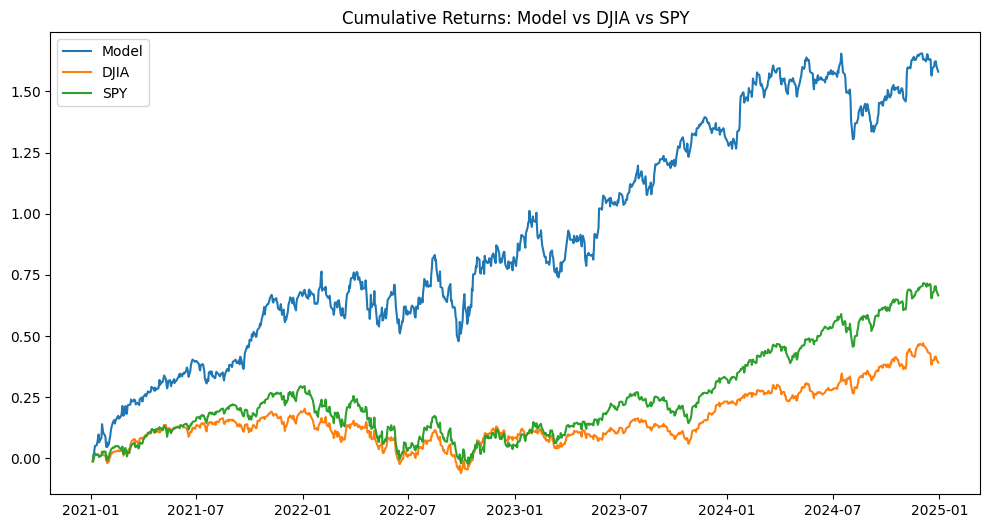

In [160]:
# Compare to becnhmarks of S&P500 and DJIA indexes

# Download index data
djia = yf.download('^DJI', start='2020-12-29', end='2024-12-31', auto_adjust=True)
spy = yf.download('SPY', start='2020-12-29', end='2024-12-31', auto_adjust=True)

# Calculate daily returns
djia['return'] = np.log(djia['Close']).diff()
spy['return'] = np.log(spy['Close']).diff()

# Align dates
data = pd.concat([daily_portfolio_returns['daily_return'], djia['return'], spy['return']], axis=1, join='inner')
data.columns = ['Model_Return', 'DJIA_Return', 'SPY_Return']

# Calculate cumulative returns
data['Model_CumReturn'] = np.exp(data['Model_Return'].cumsum()) - 1
data['DJIA_CumReturn'] = np.exp(data['DJIA_Return'].cumsum()) - 1
data['SPY_CumReturn'] = np.exp(data['SPY_Return'].cumsum()) - 1

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Model_CumReturn'], label='Model')
plt.plot(data.index, data['DJIA_CumReturn'], label='DJIA')
plt.plot(data.index, data['SPY_CumReturn'], label='SPY')
plt.legend()
plt.title('Cumulative Returns: Model vs DJIA vs SPY')
plt.show()

In [102]:
data

,Model_Return,DJIA_Return,SPY_Return,Model_CumReturn,DJIA_CumReturn,SPY_CumReturn
2021-01-04,-0.011703,-0.012579,-0.013708,-0.011635,-0.012500,-0.013614
2021-01-05,0.025645,0.005534,0.006864,0.014039,-0.007021,-0.006821
2021-01-06,0.001407,0.014303,0.005961,0.015466,0.007283,-0.000883
2021-01-07,0.021290,0.006844,0.014748,0.037318,0.014201,0.013962
2021-01-08,0.012848,0.001829,0.005681,0.050731,0.016058,0.019739
...,...,...,...,...,...,...
2024-12-23,0.003197,0.001555,0.005970,1.602041,0.401891,0.684165
2024-12-24,0.007424,0.009050,0.011054,1.621431,0.414636,0.702885
2024-12-26,0.000641,0.000664,0.000067,1.623111,0.415576,0.702998
2024-12-27,-0.007484,-0.007729,-0.010582,1.603553,0.404677,0.685072


In [148]:
# Calculate various metrics

# Constants
trading_days = 252
risk_free_rate_annual = 0.041
risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1 / trading_days) - 1

# Daily metrics
avg_daily_return = daily_portfolio_returns.mean()
daily_std = daily_portfolio_returns.std()

# Annual metrics
annual_return = np.exp(avg_daily_return * trading_days) - 1
annual_std = daily_std * np.sqrt(trading_days)

# Sharpe Ratio (excess return over risk-free)
excess_daily_return = avg_daily_return - risk_free_rate_daily
sharpe_ratio = excess_daily_return / daily_std * np.sqrt(trading_days)

# Sortino Ratio (only penalizing downside risk)
negative_returns = daily_portfolio_returns[daily_portfolio_returns < 0]
downside_std = negative_returns.std()
sortino_ratio = excess_daily_return / downside_std * np.sqrt(trading_days)

# Max and Avg Drawdown
rolling_max = cumulative_return.cummax()
drawdown = cumulative_return - rolling_max
max_drawdown = drawdown.min()
drawdown_pct = cumulative_return / rolling_max - 1
avg_drawdown = drawdown_pct[drawdown_pct < 0].mean()

# Calmar Ratio
calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

# Value at Risk (1%) and Conditional VaR
var_1 = np.percentile(daily_portfolio_returns, 1)
cvar_1 = daily_portfolio_returns[daily_portfolio_returns <= var_1].mean()

# Win Rates
plus = int((daily_portfolio_returns > 0).sum().iloc[0])
neg = int((daily_portfolio_returns < 0).sum().iloc[0])
win_rate = plus/(plus+neg)*100

# Final result as Series
metrics = {
    "Cumulative Return": cumulative_return.iloc[-1],
    "Annual Return": annual_return.item(),
    "Average Daily Return": avg_daily_return.item(),
    "Daily Std Dev": daily_std.item(),
    "Annual Std Dev": annual_std.item(),
    "Sharpe Ratio (rf=4.1%)": sharpe_ratio.item(),
    "Sortino Ratio (rf=4.1%)": sortino_ratio.item(),
    "Max Drawdown": max_drawdown,
    "Average Drawdown": avg_drawdown,
    "Calmar Ratio": calmar_ratio.item(),
    "VaR 1%": var_1.item(),
    "CVaR 1%": cvar_1.item(),
    "Winning Trades": plus,
    "Losing Trades": neg,
    "Win Rate (%)": win_rate
}

results = pd.Series(metrics).apply(lambda x: round(x, 4))
print(results)

Cumulative Return            1.5804
Annual Return                0.2686
Average Daily Return         0.0009
Daily Std Dev                0.0125
Annual Std Dev               0.1978
Sharpe Ratio (rf=4.1%)       0.9998
Sortino Ratio (rf=4.1%)      1.4514
Max Drawdown                -0.3529
Average Drawdown            -0.0954
Calmar Ratio                 0.7611
VaR 1%                      -0.0339
CVaR 1%                     -0.0395
Winning Trades             550.0000
Losing Trades              454.0000
Win Rate (%)                54.7809
dtype: float64


In [165]:
# Now we will incorporate a transaction cost of 0.02%

# Daily portfolio return
daily_portfolio_returns2 = (weights_df * actual_ret_df).sum(axis=1)
daily_portfolio_returns2 = pd.DataFrame(daily_portfolio_returns2, index=weights_df.index, columns=['daily_return'])

# Turnover
weight_diff = weights_df.diff().abs()

# Daily transaction cost (0.05% per unit turnover)
daily_tx_cost = 0.0005 * weight_diff.sum(axis=1)

# Subtract transaction cost
daily_portfolio_returns2['daily_return_net'] = daily_portfolio_returns2['daily_return'] - daily_tx_cost
daily_portfolio_returns2

,daily_return,daily_return_net
date,,
2021-01-04,-0.011703,-0.011703
2021-01-05,0.025645,0.025444
2021-01-06,0.001407,0.001314
2021-01-07,0.021290,0.021230
2021-01-08,0.012848,0.012813
...,...,...
2024-12-23,0.003197,0.003183
2024-12-24,0.007424,0.007397
2024-12-26,0.000641,0.000612


In [154]:
# Cumulative log return
cumulative_log_return2 = daily_portfolio_returns2['daily_return_net'].cumsum()

# Cumulative simple return
cumulative_return2 = np.exp(cumulative_log_return2) - 1
cumulative_return2

date
2021-01-04   -0.011635
2021-01-05    0.013835
2021-01-06    0.015168
2021-01-07    0.036951
2021-01-08    0.050323
                ...   
2024-12-23    1.479117
2024-12-24    1.497523
2024-12-26    1.499051
2024-12-27    1.480352
2024-12-30    1.458204
Name: daily_return_net, Length: 1004, dtype: float64

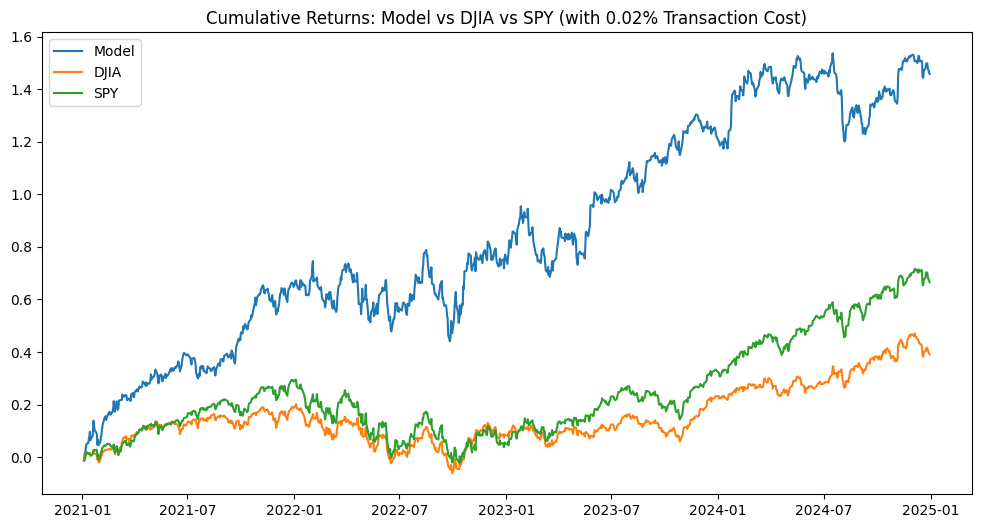

In [161]:
# Compare to becnhmarks of S&P500 and DJIA indexes

# Plot cumulative returns
plt.figure(figsize=(12,6))
plt.plot(data.index, cumulative_return2, label='Model')
plt.plot(data.index, data['DJIA_CumReturn'], label='DJIA')
plt.plot(data.index, data['SPY_CumReturn'], label='SPY')
plt.legend()
plt.title('Cumulative Returns: Model vs DJIA vs SPY (with 0.02% Transaction Cost)')
plt.show()

In [166]:
# Calculate various metrics

# Constants
trading_days = 252
risk_free_rate_annual = 0.041
risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1 / trading_days) - 1

daily_portfolio_returns2 = daily_portfolio_returns2['daily_return_net']

# Daily metrics
avg_daily_return = daily_portfolio_returns2.mean()
daily_std = daily_portfolio_returns2.std()

# Annual metrics
annual_return = np.exp(avg_daily_return * trading_days) - 1
annual_std = daily_std * np.sqrt(trading_days)

# Sharpe Ratio (excess return over risk-free)
excess_daily_return = avg_daily_return - risk_free_rate_daily
sharpe_ratio = excess_daily_return / daily_std * np.sqrt(trading_days)

# Sortino Ratio (only penalizing downside risk)
negative_returns = daily_portfolio_returns2[daily_portfolio_returns2 < 0]
downside_std = negative_returns.std()
sortino_ratio = excess_daily_return / downside_std * np.sqrt(trading_days)

# Max and Avg Drawdown
rolling_max = cumulative_return2.cummax()
drawdown = cumulative_return2 - rolling_max
max_drawdown = drawdown.min()
drawdown_pct = cumulative_return2 / rolling_max - 1
avg_drawdown = drawdown_pct[drawdown_pct < 0].mean()

# Calmar Ratio
calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

# Value at Risk (1%) and Conditional VaR
var_1 = np.percentile(daily_portfolio_returns2, 1)
cvar_1 = daily_portfolio_returns2[daily_portfolio_returns2 <= var_1].mean()

# Win Rates
plus = int((daily_portfolio_returns2 > 0).sum())
neg = int((daily_portfolio_returns2 < 0).sum())
win_rate = plus/(plus+neg)*100

# Final result as Series
metrics = {
    "Cumulative Return": cumulative_return2.iloc[-1],
    "Annual Return": annual_return.item(),
    "Average Daily Return": avg_daily_return.item(),
    "Daily Std Dev": daily_std.item(),
    "Annual Std Dev": annual_std.item(),
    "Sharpe Ratio (rf=4.1%)": sharpe_ratio.item(),
    "Sortino Ratio (rf=4.1%)": sortino_ratio.item(),
    "Max Drawdown": max_drawdown,
    "Average Drawdown": avg_drawdown,
    "Calmar Ratio": calmar_ratio.item(),
    "VaR 1%": var_1.item(),
    "CVaR 1%": cvar_1.item(),
    "Winning Trades": plus,
    "Losing Trades": neg,
    "Win Rate (%)": win_rate
}

results = pd.Series(metrics).apply(lambda x: round(x, 4))
print(results)

Cumulative Return            1.4582
Annual Return                0.2533
Average Daily Return         0.0009
Daily Std Dev                0.0125
Annual Std Dev               0.1978
Sharpe Ratio (rf=4.1%)       0.9380
Sortino Ratio (rf=4.1%)      1.3603
Max Drawdown                -0.3478
Average Drawdown            -0.1008
Calmar Ratio                 0.7282
VaR 1%                      -0.0344
CVaR 1%                     -0.0396
Winning Trades             548.0000
Losing Trades              456.0000
Win Rate (%)                54.5817
dtype: float64
